# Self-Driving Car Engineer Nanodegree
## Project: **Finding Lane Lines on the Road** 
***
### Import Libraries

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os
%matplotlib inline

### Step 1: Read an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


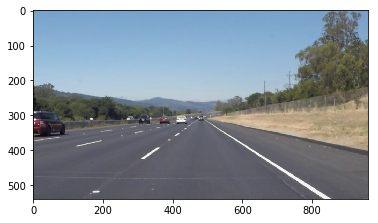

In [2]:
image = mpimg.imread('test_images/solidWhiteRight.jpg')

print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)

### Step 2: Gray Scale Transformation

In [3]:
def grayscale(img):
    """
    Applies gray scale transformation
    
    Arguments:
        An image with three color channels
    Returns: 
        AN image with only one color channel
    """    
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

### Step 3: Gaussian Smoothening

In [4]:
def gaussian_blur(img, kernel_size):
    """
    Applies a Gaussian Noise kernel
    
    Arguments:
        img-- input image
        kernel_size-- kerner size for the gaussian filter, scalar value
    Returns:
        Image with blurred characterstics, intensity depending on the size of the kernel used
    """
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

### Step 4: Applying Canny Edge Detection

In [5]:
def canny(img, low_threshold, high_threshold):
    """
    Applies the Canny transform to the gaussian blurred gray scaled image
    
    Arguments:
        img--input image
        low_threshold-- 
        high-threshold-- 
    Returns:
        Image containing detected edges in the input image
    """
    return cv2.Canny(img, low_threshold, high_threshold)

### Step 5: Selecting Region of Interest

In [6]:
def region_of_interest(img, vertices):
    """
    Applies an image mask. Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    
    Arguments:
        img--input image
        vertices-- numpy array of integer points
    Returns:
        masked image with region of interest
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    
    return masked_image

### Step 6: Performing Hough Transform on Masked Image

In [7]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    This function draws `extrapolated lines` with `color` and `thickness` on input image.    
    
    Arguments:
        img: Lines are drawn on this input image
        lines: array containing the endpoints of the line segments detected by hough transform
    """
    x_left = []
    x_right = []
    y_left = []
    y_right = []
    imshape = img.shape
    for line in lines:
        for x1, y1, x2, y2 in line:
            slope = (y2-y1)/(x2-x1)
            if slope < 0:
                x_left = x_left + [x1, x2]
                y_left = y_left + [y1, y2]
            else:
                x_right = x_right + [x1, x2]
                y_right = y_right + [y1, y2]

    #finding m and b that fits x,y coordinates            
    z_left = np.polyfit(x_left, y_left, 1)
    z_right = np.polyfit(x_right, y_right, 1)
    
    #calculates y=mx+b
    f_left = np.poly1d([1/z_left[0],-z_left[1]/z_left[0]])
    f_right = np.poly1d([1/z_right[0],-z_right[1]/z_right[0]])

    cv2.line(img, (int(f_left(imshape[0])), imshape[0]), (int(f_left(imshape[0]*0.6)),int(imshape[0]*0.6)), color, thickness)
    cv2.line(img, (int(f_right(imshape[0])), imshape[0]), (int(f_right(imshape[0]*0.6)),int(imshape[0]*0.6)), color, thickness)   

In [8]:
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    Transforms hough transform on a canny tranformed image
    
    Arguments:
        img: Input image which is output of a Canny transform
        rho,theta: Distance and Angular resolution for the grid in hough space(pixel,radian)
        threshold: Minimum number of intersections, in grid cell, a line needs to have to make it into output
        min_line_len: Minimum length of line to be accepted in the output(in pixels)
        max_line_gap: Maximum distance between segments that will be allowed to connect into a single line
    Returns:
        An image with hough lines drawn
    """
    #'lines' will be array containing the endpoints of the line segments detected by transform 
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    #Creating a blank image to draw line on it
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
   
    #Using the array of 'lines' drawing lines defined above
    draw_lines(line_img, lines)
    
    return line_img

### Step 7: Drawing the line_image obtained on the original un processed image

In [9]:
def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    Arguments:
        img: Output of the hough_lines(), An image with lines drawn on it,
             should be a blank image (all black) with lines drawn on it.
        initial_img: Original image before any processing
    Returns:
        The result image is computed as: initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

### Complete Package:

In [10]:
def image_pipeline(image):
# def image_pipeline(file_path):     #while running this pipeline on video comment this line
#     image= mpimg.imread(file_path) #and this line and uncomment the first and last line
    fig=plt.figure()
    plt.imshow(image)
    plt.title('Original Image')
    fig.savefig('output_images/OriginalImage.png')

    gray_image = grayscale(image)
    fig=plt.figure()
    plt.imshow(gray_image,cmap='gray')
    plt.title('Gray Scaled Image')
    fig.savefig('output_images/GrayScaledImage.png')

    kernel_size = 3
    gray_image = gaussian_blur(gray_image, kernel_size)
    fig=plt.figure()
    plt.imshow(gray_image,cmap='gray')
    plt.title('Gaussian Smoothened Image')
    fig.savefig('output_images/GaussianSmoothenedImage.png')

    low_threshold = 50
    high_threshold = 150
    edge_image = canny(gray_image, low_threshold, high_threshold)
    fig=plt.figure()
    plt.imshow(edge_image,cmap='Greys_r')
    plt.title('Canny Edge Detected Image')
    fig.savefig('output_images/EdgeImage.png')
    
    imshape = image.shape
    vertices = np.array([[(imshape[1]*0.15,imshape[0]),(imshape[1]*0.45, imshape[0]*0.6), 
                          (imshape[1]*0.6, imshape[0]*0.6), (imshape[1]*0.95,imshape[0])]], dtype=np.int32)
    masked_edge_image = region_of_interest(edge_image, vertices)
    fig=plt.figure()
    plt.imshow(masked_edge_image,cmap='Greys_r')
    plt.title('Edge Image with Region of Interest')
    fig.savefig('output_images/MaskedEdgeImage.png')
    
    rho = 2
    theta = np.pi/180
    threshold = 15
    min_line_len = 40
    max_line_gap = 20
    line_image = hough_lines(masked_edge_image, rho, theta, threshold, min_line_len, max_line_gap)
    fig=plt.figure()
    plt.imshow(line_image,cmap='Greys_r')
    plt.title('Hough Lines')
    fig.savefig('output_images/HoughLineImage.png')
    
    output_image = weighted_img(line_image, image, α=0.8, β=1., γ=0.)
    fig=plt.figure()
    plt.imshow(output_image)
    plt.title('Output Image')
    fig.savefig('output_images/OutputImage.png')
    return output_image

### Implementing on single image:

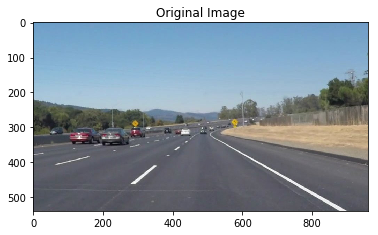

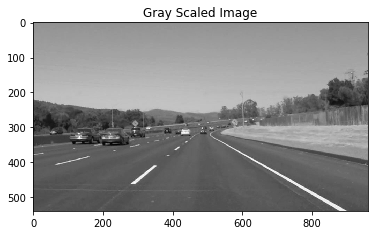

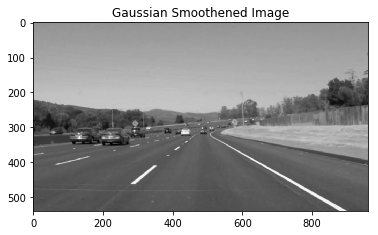

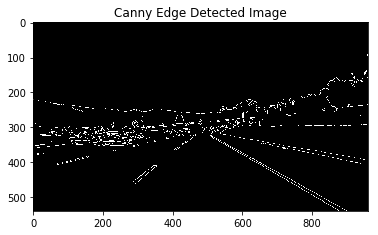

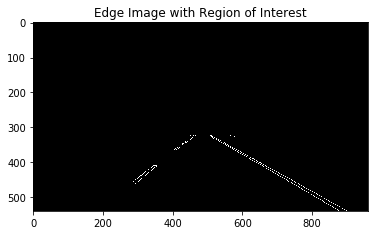

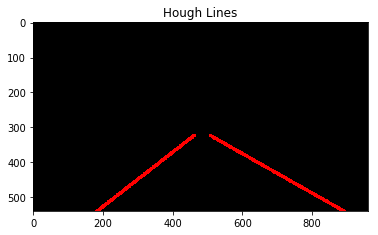

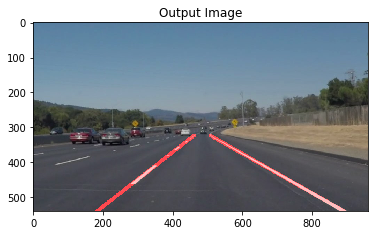

In [12]:
image_pipeline("test_images/solidWhiteCurve.jpg")
# for file in os.listdir("test_images/"):
#     file_path=os.path.join("test_images/",file)
#     image_pipeline(file_path)

In [12]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

### Implementation on different videos:

In [ ]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
# clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(image_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|███████████████████████████████████████▊| 221/222 [07:45<00:02,  2.37s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 7min 49s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


  0%|                                          | 1/682 [00:02<27:03,  2.38s/it]WARNING:py.warnings:C:\Users\sanke_000\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)

  7%|██▉                                      | 48/682 [01:48<23:34,  2.23s/it]

KeyboardInterrupt: 

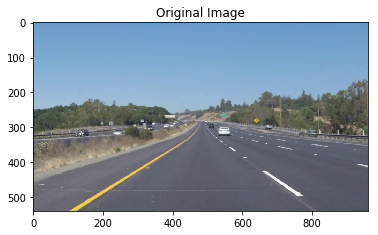

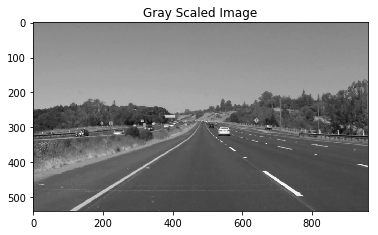

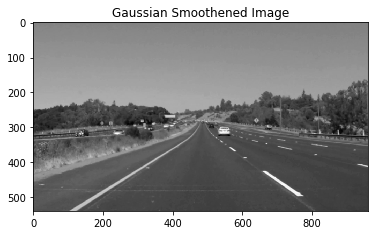

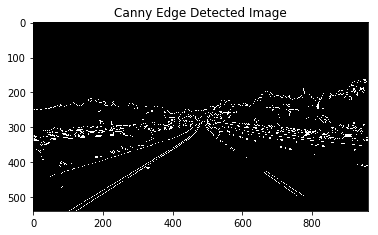

ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "C:\Users\sanke_000\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\sanke_000\Anaconda3\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\sanke_000\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\sanke_000\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\sanke_000\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\sanke_000\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "

In [ ]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(image_pipeline)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

In [ ]:
challenge_output = 'test_videos_output/challenge.mp4'
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(image_pipeline)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))